# General setup

In [1]:
import os, sys, subprocess
import time
from glob import glob
import itertools
from functools import partial
import copy
import gc

import importlib
sys.path.insert(1, os.path.realpath('..'))
sys.path.insert(1, os.path.realpath('../../PyTorchShared'))
if "utils" not in sys.modules: import utils
else: importlib.reload(utils)
if "ml" not in sys.modules: import ml
else: importlib.reload(ml)
if "train" not in sys.modules: import train
else: importlib.reload(train)

# >>>
import ipynbname
nb_base = ipynbname.name().split('_')[0]
# <<<

import numpy as np

# >>>
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
import h5py
import csv
# <<<

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
if not utils.is_notebook():
    import torch.multiprocessing as mp

In [2]:
# >>>
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# <<<

Using cuda device


# Loading Data

In [3]:
transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

raw_train_dataset = MNIST(
    root="../../../PyTorchShared/Datasets",
    train=True,
    download=True,
    transform=transform
)

raw_test_dataset = MNIST(
    root="../../../PyTorchShared/Datasets",
    train=False,
    download=True,
    transform=transform
)

Shape of X [N, C, H, W]:  torch.Size([16, 1, 28, 28])
Shape of y:  torch.Size([16]) torch.int64
Shape of z:  torch.Size([16]) torch.int64


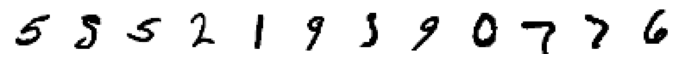

tensor([5, 5, 5, 2, 1, 9, 5, 9, 0, 7, 7, 6])
tensor([ 6,  1, 13,  2, 19, 10, 17,  2,  0, 16, 16, 12])


In [4]:
# >>>
preview_dataloader = DataLoader(
    ml.RelabeledSubset(raw_train_dataset, class_size=100,
                       target2_config=20, transform=transform),
    batch_size=16, shuffle=True)

X, y, z = next(iter(preview_dataloader))
print("Shape of X [N, C, H, W]: ", X.shape)
print("Shape of y: ", y.shape, y.dtype)
print("Shape of z: ", z.shape, z.dtype)
    
utils.plot_images(X.clamp_(-1, 1), num=12)
print(y[:12])
print(z[:12])
# <<<

# Training

In [5]:
HIDDEN_SIZE = 50
CLASS_SIZES = [20, 40, 60, 80, 100]
num_sizes = len(CLASS_SIZES)
BATCH_SIZE = 50
NUM_EPISODES = 10

DECORR_STRENGTH = 0.5
NUM_REPLICATES = 32

class_sizes = [rep
               for size in CLASS_SIZES
               for rep in (size,)*NUM_REPLICATES]*2
decorr_criteria = [rep
                   for criterion in (None, ml.decorr_criterion)
                   for rep in (criterion,)*NUM_REPLICATES*num_sizes]

MODE = 'episode'

train_datasets = [(
    ml.RelabeledSubset,
    dict(dataset=raw_train_dataset, class_size=class_size,
         target2_config=NUM_EPISODES, transform=transform)
) for class_size in class_sizes]
test_dataset = None 

model = (
    ml.MLP,
    dict(hidden_size=HIDDEN_SIZE, target_size=NUM_EPISODES,
         nonlinearity1=nn.Tanh(), nonlinearity2=nn.Tanh())
)

devices = itertools.cycle([torch.device('cuda', i)
                           for i in range(torch.cuda.device_count())])

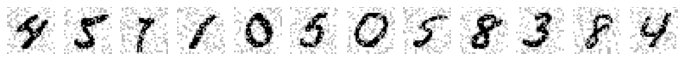

In [6]:
NUM_EPOCHS = 100
PRINT_EPOCHS = 0
LR_MILESTONES = [NUM_EPOCHS]
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0

def NOISE_FN(data):
    mask = torch.rand_like(data)
    threshold = mask.quantile(0.2)
    mask = (mask - threshold > 0).float()
    noisy_data = data * mask
    return noisy_data

# >>>
X, _, _ = next(iter(preview_dataloader))
noisy_X = NOISE_FN(X)
utils.plot_images(noisy_X.clamp_(-1., 1.), num=12)
# <<<

In [7]:
kwargs_map = [dict(device=dev,
                   train_dataset=param0,
                   decorr_criterion=param1)
               for dev, param0, param1
               in zip(devices,
                      train_datasets,
                      decorr_criteria)]
kwargs_partial = dict(model=model,
                      mode=MODE,
                      test_dataset=test_dataset,
                      decorr_strength=DECORR_STRENGTH,
                      noise_fn=NOISE_FN,
                      batch_size=BATCH_SIZE,
                      learning_rate=LEARNING_RATE,
                      lr_milestones=LR_MILESTONES,
                      num_epochs=NUM_EPOCHS,
                      print_epochs=PRINT_EPOCHS)
# >>>
kwargs_map[0]
# <<<

{'device': device(type='cuda', index=0),
 'train_dataset': (ml.RelabeledSubset,
  {'dataset': Dataset MNIST
       Number of datapoints: 60000
       Root location: ../../../PyTorchShared/Datasets
       Split: Train
       StandardTransform
   Transform: Compose(
                  ToTensor()
                  Normalize(mean=(0.1307,), std=(0.3081,))
              ),
   'class_size': 20,
   'target2_config': 10,
   'transform': Compose(
       ToTensor()
       Normalize(mean=(0.1307,), std=(0.3081,))
   )}),
 'decorr_criterion': None}

In [8]:
# >>>
i_train = -1
print(model)
utils.start_timer()
result = train.train(
    **(kwargs_partial | {'print_epochs': 5}),
    **kwargs_map[i_train]
)
utils.end_timer_and_print()
# <<<

(<class 'ml.MLP'>, {'hidden_size': 50, 'target_size': 10, 'nonlinearity1': Tanh(), 'nonlinearity2': Tanh()})
cuda:7   0)   target:  2.328  decorr:  7.527   train: 0.095  test: 0.100
cuda:7   4)   target:  2.282  decorr:  2.340   train: 0.143  test: 0.149
cuda:7   9)   target:  2.240  decorr:  1.632   train: 0.188  test: 0.197
cuda:7  14)   target:  2.197  decorr:  1.465   train: 0.236  test: 0.227
cuda:7  19)   target:  2.147  decorr:  1.396   train: 0.272  test: 0.266
cuda:7  24)   target:  2.079  decorr:  1.293   train: 0.329  test: 0.293
cuda:7  29)   target:  1.991  decorr:  1.233   train: 0.384  test: 0.352
cuda:7  34)   target:  1.875  decorr:  1.205   train: 0.449  test: 0.407
cuda:7  39)   target:  1.735  decorr:  1.179   train: 0.516  test: 0.467
cuda:7  44)   target:  1.564  decorr:  1.159   train: 0.581  test: 0.502
cuda:7  49)   target:  1.368  decorr:  1.185   train: 0.664  test: 0.554
cuda:7  54)   target:  1.165  decorr:  1.178   train: 0.741  test: 0.612
cuda:7  59)   t

In [9]:
if not utils.is_notebook():
    train_partial = partial(train.train, **kwargs_partial)
   
    MAX_PROCESSES = 2 * torch.cuda.device_count()
    
    if __name__ == "__main__":
        utils.start_timer()
        mp.set_start_method('spawn', force=True)
        
        num_processes = min(len(kwargs_map), MAX_PROCESSES)
        with mp.Pool(num_processes) as p:
            results = utils.kwstarmap(p, train_partial, kwargs_map)

        utils.end_timer_and_print()

In [10]:
# >>$ exclude from script to end of notebook
subprocess.call(["/bin/zsh", "-ic",
                 f"nb2script {nb_base}.ipynb"])

[NbConvertApp] Converting notebook sweep-episode10.ipynb to script
[NbConvertApp] Writing 6403 bytes to sweep-episode10_nb.py


0

In [11]:
nb_script = f"{nb_base}_nb.py"
%run -i $nb_script


Total execution time 140.088 sec


# Results

In [12]:
losses = np.array([result[0] for result in results])
train_accuracies = np.array([result[1] for result in results])
test_accuracies = np.array([result[2] for result in results])

In [13]:
if "h5file" in globals():
    h5file.close()
h5file = h5py.File(f"results/{nb_base}.h5", 'w')

h5file.create_dataset("class_sizes", data=class_sizes)
h5file.create_dataset("losses", data=losses)
h5file.create_dataset("train_accuracies", data=train_accuracies)
h5file.create_dataset("test_accuracies", data=test_accuracies)

h5file.close()

In [14]:
sizes_by_criterion = np.array(class_sizes).reshape((2,-1))
accuracies_by_criterion = test_accuracies[:,-1].reshape((2,-1))

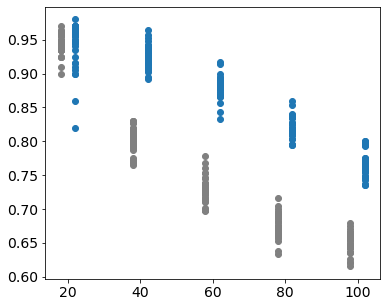

In [15]:
colors = ('0.5', 'tab:blue')
shift = 0.10
shift_facs = sizes_by_criterion[0, 0] * np.array((-shift, shift))

fig, ax = plt.subplots(figsize=(6, 5))
for sizes, accuracies, shift, color \
in zip(sizes_by_criterion, accuracies_by_criterion, shift_facs, colors):
    ax.scatter(sizes + shift, accuracies, color=color)
ax.set_xticks(CLASS_SIZES)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
fig.show()